# How to use the Vcsn library

## Writing your own code

Writing programs with Vcsn is quite simple once you're familiar with the library.

### Static

When using the static version of the library, use algorithms from the `vcsn::` namespace. These algorithms are highly templated and hence require the user to know the context and parameters of these algorithms at compile time.
This part of the library provides less flexibility but ensures that all of the required code will be compiled before runtime.

### Dyn

The dyn version of the library consists of algorithms from the `vcsn::dyn::` namespace. These algorithms provide an abstraction from the static library that hides from users the actual fully templated versions of algorithms. This allows more flexibility as the user does not have to know the context of automata at compile time and new types of automata can be created at runtime. However, algorithms may need to be compiled at runtime, lowering the program's performances (once compiled algorithms are cached and can be used without further compilation though).

## Compiling with Vcsn

Compiling your program will then require to use the Vcsn program with the compiler option and can be done as such:

    $ vcsn compile source.cc

It is also possible to modify the programs compilation options and compiler in the command line option:

    $ vcsn compile CXX='g++' CXXFLAGS+='-g3' source.cc

Run `vcsn compile --help` for additional options.  This page provides examples of use of `vcsn compile`, see below.

## Running the code

When actually running the program you just compiled you _might_ have to use the Vcsn program as well through the run option:

    $ vcsn run my-prog args...

The command can be followed directly by the arguments of your program.

Possibly just running `my-prog` would work too, but it depends on your setup.  In case of doubt, use `vcsn run`.

# Examples

More samples of code are present in the `tests/demo` directory of the project from which you can inspire yourself.

In [1]:
import vcsn

##  Operators of labels, expressions, etc.
This a simple example which shows how to build `dyn` labels, weights, etc. and how to manipulate them with operators such as `+`.

For a start, labels are the simplest objects: you can hardly do more that concatenating them, thanks to `*`.  You may also run `multiply(a, b)` instead of `a * b`.  The following examples shows how to compare labels too.

In [2]:
# Don't worry about this "magic" line: it selects some lines from
# the `operators.cc` file, and pretty-prints them.
!perl -ne '(/labels:/ ... /labels:/) && !/labels:/ && print' ../../tests/demo/operators.cc | pygmentize -l c++ 

  void
  labels()
  {
    using namespace vcsn::dyn;
    // Labels are words, not letters.
    auto ctx = make_context("law, q");

    auto a = make_label(ctx, "a");
    auto b = make_label(ctx, "b");
    auto abba = make_label(ctx, "abba");

    // Labels can be compared.
    ASSERT(a == a);
    ASSERT(a != b);
    ASSERT(a < b);
    ASSERT(a <= b);
    ASSERT(b > a);
    ASSERT(b >= a);

    // This is the lexicographical order.
    ASSERT(a < abba);
    ASSERT(abba < b);

    // They also support multiplication (i.e., concatenation) when
    // possible: concatenation of labels-are-letters does not work, of
    // course.  That's why the context here is using labels-are-words.
    ASSERT(a * b * b * a == abba);
  }


Weights are more capables than labels: in addition to multiplication, they support conjunction and addition.

In [3]:
!perl -ne '(/weights:/ ... /weights:/) && !/weights:/ && print' ../../tests/demo/operators.cc | pygmentize -l c++ 

  void
  weights()
  {
    using namespace vcsn::dyn;

    // This context specifies that weights are rational numbers (ℚ).
    auto ctx = make_context("lal, q");

    auto one = make_weight(ctx, "1");
    auto two = make_weight(ctx, "2");
    auto half = make_weight(ctx, "1/2");

    // Weights can be compared.
    ASSERT(one != two);
    ASSERT(one == one);
    ASSERT(one < two);
    ASSERT(one <= two);
    ASSERT(two > one);
    ASSERT(two >= one);

    // 1+1 = 2, etc.
    ASSERT(one + one == two);
    ASSERT(half + half == one);

    // 1/2 * 2 = 1.
    ASSERT(half * two == one);

    // (1/2)* = 2.
    ASSERT(half * -1 == two);
  }


Of course, expressions are more interesting: they support a wide range of operators, and many functions.

In [4]:
!perl -ne '(/expressions:/ ... /expressions:/) && !/expressions:/ && print' ../../tests/demo/operators.cc | pygmentize -l c++ 

  void
  expressions()
  {
    using namespace vcsn::dyn;
    // A simple context.
    auto ctx = make_context("lal, q");

    // Create an expression, and pretty-print it.
    auto e1 = make_expression(ctx, "<2>a");
    ASSERT(format(e1) == "<2>a");
    auto e2 = make_expression(ctx, "<3>b");

    ASSERT(format(e1 + e2) == "<2>a+<3>b");
    ASSERT(format(e1 * e2) == "<6>(ab)");

    // e * -1 denotes e to the -1, that is e*.
    auto e = ((e1 + e2) * -1) * e1 * (e1 + e2);
    ASSERT(format(e) == "<2>((<2>a+<3>b)*a(<2>a+<3>b))");
  }


Automata also offer a rich feature set.

In [5]:
!perl -ne '(/automata:/ ... /automata:/) && !/automata:/ && print' ../../tests/demo/operators.cc | pygmentize -l c++ 

  void
  automata()
  {
    using namespace vcsn::dyn;
    // A simple automaton.
    auto a1 = make_automaton("context = lal, q\n"
                             "$ 0 <1/2>\n"
                             "0 1 <2>a, <6>b\n"
                             "1 $\n");
    // Its context.
    auto ctx = context_of(a1);

    // Evaluate it.
    ASSERT(evaluate(a1, make_word(ctx, "a")) == make_weight(ctx, "1"));
    ASSERT(evaluate(a1, make_word(ctx, "b")) == make_weight(ctx, "3"));

    // Concatenate to itself.
    auto a2 = a1 * a1;
    ASSERT(evaluate(a2, make_word(ctx, "ab")) == make_weight(ctx, "3"));
    ASSERT(evaluate(a2, make_word(ctx, "bb")) == make_weight(ctx, "9"));

    // Self-conjunction, aka "power 2".
    auto a3 = a1 & a1;
    ASSERT(evaluate(a3, make_word(ctx, "a")) == make_weight(ctx, "1"));
    ASSERT(evaluate(a3, make_word(ctx, "b")) == make_weight(ctx, "9"));
  }


##  Manipulating automata: `prod-eval`
The following example shows how to use basic operations on automata to implement a simple processing: load two automata, compute their conjunction, and evaluate a word on it.  It is implemented twice: once in `dyn::` and then in the static library, `vcsn::`.

The `dyn` version is straightforward, users do not have to have to track exact types of the automata, labels and weights.

In [6]:
!perl -ne '(/dyn: begin/ ... /dyn: end/) && !/dyn:/ && print' ../../tests/demo/prod-eval.cc | pygmentize -l c++ 

/// Dyn implementation of the prod_eval.
///
/// Read two automata and a word. Compute the product of these automata and
/// evaluate the word on it. The context does not have to be specified as
/// the context of the parameters is computed dynamically.
///
/// \param lhs  name of a file containing the first automaton
/// \param rhs  name of a file containing the second automaton
/// \param word the word to evaluate
static void
dyn_prod_eval(const std::string& lhs, const std::string& rhs,
              const std::string& word)
{
  using namespace vcsn::dyn;
  // Left and right automata.  A simple type, not parameterized.
  automaton l = read_automaton(lhs);
  automaton r = read_automaton(rhs);
  // The synchronized product.
  automaton prod = conjunction(l, r);
  // The word to evaluate in prod.
  label input = read_word(context_of(prod), word);
  // The result weight from the evaluation.
  weight w = evaluate(prod, input);
  // Display of the result, no need to use the weightset.
  st

The static implementation is templated by a [context](Contexts.ipynb), i.e., a specific type of labelset and weightset.

In [7]:
!perl -ne '(/static: begin/ ... /static: end/) && !/static:/ && print' ../../tests/demo/prod-eval.cc | pygmentize -l c++ 

/// Static implementation of the prod_eval.
///
/// Read two automata and a word. Compute the product of these
/// automata and evaluate the word on it.
///
/// \tparam Ctx the specified context of the automata and the
///    word. Each of them have to be from these context or the program
///    will fail.
///
/// \param lhs  name of a file containing the first automaton
/// \param rhs  name of a file containing the second automaton
/// \param word the word to evaluate
template <typename Ctx>
void
sta_prod_eval(const std::string& lhs, const std::string& rhs,
              const std::string& word)
{
  using namespace vcsn;
  // The automata's exact type.
  using automaton_t = mutable_automaton<Ctx>;
  // Left and right automata.
  automaton_t l = read_automaton<automaton_t>(lhs);
  automaton_t r = read_automaton<automaton_t>(rhs);
  // The synchronized product.  Stripped to retrieve the same type of
  // automata as l and r.
  automaton_t prod = conjunction<automaton_t, automaton_t>(l, 

Compile the prod-eval program using `vcsn compile`.  To know exactly what is going on, pass the option `-v`/`--verbose`.

In [8]:
!vcsn compile -q ../../tests/demo/prod-eval.cc

Now we generate two input automata for the prod-eval program.  Here, we generate them via the command line tool `vcsn` (see [Executables](Executables.ipynb)), with the command `standard`, which corresponds to [`expression.standard`](expression.standard.ipynb).

In [9]:
!vcsn standard -C 'lal_char(01), z' -Ee '(0+1)*1(<2>0+<2>1)*' -o bin.gv
!vcsn standard -C 'lal_char(01), z' -Ee '(0+1)*0'             -o even.gv

The following automaton, `bin`, decodes binary into decimal values.

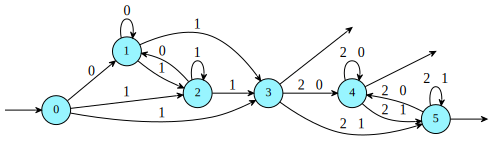

In [10]:
bin = vcsn.automaton(filename='bin.gv')
bin

This automaton, `even`, only accepts even numbers.

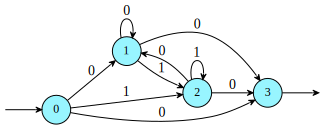

In [11]:
even = vcsn.automaton(filename='even.gv')
even

Now we run `prod-eval` to evaluate words on the synchronized product of `bin` and `even`.
The result is the value denoted by this binary number if it is even else 0.
The result is displayed twice, once for the dyn implementation and once for static one.

In [12]:
!for i in 0 1 10 1110 101010 101011;                       \
do                                                         \
    printf "%6s: " $i;                                     \
    vcsn run ../../tests/demo/prod-eval bin.gv even.gv $i; \
done

     0: 0, 0
     1: 0, 0
    10: 2, 2
  1110: 14, 14
101010: 42, 42
101011: 0, 0


For the record, this could have been done this way in Python:

In [13]:
for i in [0, 1, 10, 1110, 101010, 101011]:
    print('{:6d}: {}'.format(i, (bin & even).evaluate(i)))

     0: 0
     1: 0
    10: 2
  1110: 14
101010: 42
101011: 0


##  Low-level manipulation of automata: `compose`
This example shows how to build a multitape automaton (adding states and transitions), and how to use it.

In [14]:
!pygmentize -l c++ ../../tests/demo/compose.cc 

#include <iostream> //std::cout

#include <vcsn/alphabets/char.hh> // type of letter
#include <vcsn/alphabets/setalpha.hh> // alphabet
#include <vcsn/algos/compose.hh> // composition algorithm
#include <vcsn/algos/dot.hh> // display algorithm
#include <vcsn/labelset/tupleset.hh> // tupleset
#include <vcsn/labelset/letterset.hh> // letterset
#include <vcsn/weightset/b.hh> // weightset b

// Example usage of Vcsn's static layer.
//
// Creation of an automaton, composition, then display.
int main()
{
  using namespace vcsn;

  // Basic alphabet type.
  using alphabet_t = set_alphabet<char_letters>;

  // Letterset (single-tape labelset).
  using letterset_t = letterset<alphabet_t>;

  // Create the letterset.
  auto ls1 = letterset_t{'a'};

  // Labelset (double-tape).
  using labelset_t = tupleset<letterset_t, letterset_t>;

  // Create the double-tape labelset.
  auto ls = labelset_t{ls1, ls1};


  // Context of the automaton: lat<lal_char, lal_char>, b.
  using context_t = context<labe